# Data Augmentation Experiments

This notebook helps you:
- Test different augmentation techniques
- Compare augmentation strategies
- Visualize augmentation effects
- Optimize augmentation parameters

In [12]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import yaml
import random
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append('../src')
from data_augmentation import AugmentedColorDataset, AugmentationVisualizer, create_augmented_dataset
from data_preprocessing import DataPreprocessor
from utils import compare_images_side_by_side

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")

Libraries imported successfully!
PyTorch version: 2.8.0+cpu


## 1. Load Configuration and Check Data

In [13]:
# Load configurations
config_path = "../config/config.yaml"
aug_config_path = "../config/augmentation_config.yaml"

with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

with open(aug_config_path, 'r') as f:
    aug_config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"Current augmentation strategy: {aug_config['current_strategy']}")
print(f"Augmentation enabled: {aug_config['augmentation']['enabled']}")

# Check processed data
processed_dir = "../data/processed"
train_dir = os.path.join(processed_dir, "train")

if not os.path.exists(train_dir):
    print("\n❌ Processed data not found!")
    print("Please run notebook 02_data_preprocessing.ipynb first.")
else:
    image_count = len([f for f in os.listdir(train_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    print(f"\n✓ Found {image_count} processed training images")
    
    if image_count == 0:
        print("No images found in processed directory!")

Configuration loaded:
Current augmentation strategy: medium
Augmentation enabled: True

✓ Found 9 processed training images


## 2. Preview Augmentation Strategies

In [14]:
# Display available augmentation strategies
print("Available Augmentation Strategies:")
print("=" * 50)

strategies = aug_config['strategies']
for strategy_name, strategy_config in strategies.items():
    print(f"\n{strategy_name.upper()} Strategy:")
    print(f"  Geometric probability: {strategy_config['geometric_prob']}")
    print(f"  Photometric probability: {strategy_config['photometric_prob']}")
    print(f"  Advanced probability: {strategy_config['advanced_prob']}")

# Show detailed augmentation settings
print("\nDetailed Augmentation Settings:")
print("-" * 30)

aug_settings = aug_config['augmentation']
print(f"Overall probability: {aug_settings['probability']}")

print("\nGeometric augmentations:")
for aug_name, aug_params in aug_settings['geometric'].items():
    if aug_params['enabled']:
        print(f"  ✓ {aug_name}: p={aug_params['probability']}")
    else:
        print(f"  ✗ {aug_name}: disabled")

print("\nPhotometric augmentations:")
for aug_name, aug_params in aug_settings['photometric'].items():
    if aug_params['enabled']:
        print(f"  ✓ {aug_name}: p={aug_params['probability']}")
    else:
        print(f"  ✗ {aug_name}: disabled")

Available Augmentation Strategies:

LIGHT Strategy:
  Geometric probability: 0.3
  Photometric probability: 0.2
  Advanced probability: 0.1

MEDIUM Strategy:
  Geometric probability: 0.5
  Photometric probability: 0.4
  Advanced probability: 0.2

HEAVY Strategy:
  Geometric probability: 0.7
  Photometric probability: 0.6
  Advanced probability: 0.3

Detailed Augmentation Settings:
------------------------------
Overall probability: 0.8

Geometric augmentations:
  ✓ horizontal_flip: p=0.5
  ✗ vertical_flip: disabled
  ✓ rotation: p=0.4
  ✓ random_scale: p=0.3
  ✓ shift_scale_rotate: p=0.3

Photometric augmentations:
  ✓ brightness_contrast: p=0.4
  ✓ hue_saturation: p=0.3
  ✓ gamma_transform: p=0.2
  ✗ random_fog: disabled
  ✓ gaussian_noise: p=0.2


## 3. Test Augmentation on Sample Images

In [16]:
# Create augmentation visualizer
import os
if os.path.exists(train_dir) and len(os.listdir(train_dir)) > 0:
    visualizer = AugmentationVisualizer(aug_config_path)
    
    # Get a sample image
    sample_files = [f for f in os.listdir(train_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if sample_files:
        sample_image = os.path.join(train_dir, sample_files[0])
        print(f"Testing augmentation on: {sample_files[0]}")
        
        # Preview augmentations
        visualizer.preview_augmentations(
            sample_image, 
            num_samples=6,
            save_path="../results/augmentation_preview.png"
        )
    else:
        print("No sample images found for augmentation testing")
else:
    print("No processed training data available for testing")

Testing augmentation on: 1.jpg


NameError: name 'os' is not defined

## 4. Compare Different Augmentation Strategies

Comparing augmentation strategies...
Testing light strategy...


ValueError: 1 validation error for InitSchema
sigma
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='120 * 0.05', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/float_parsing

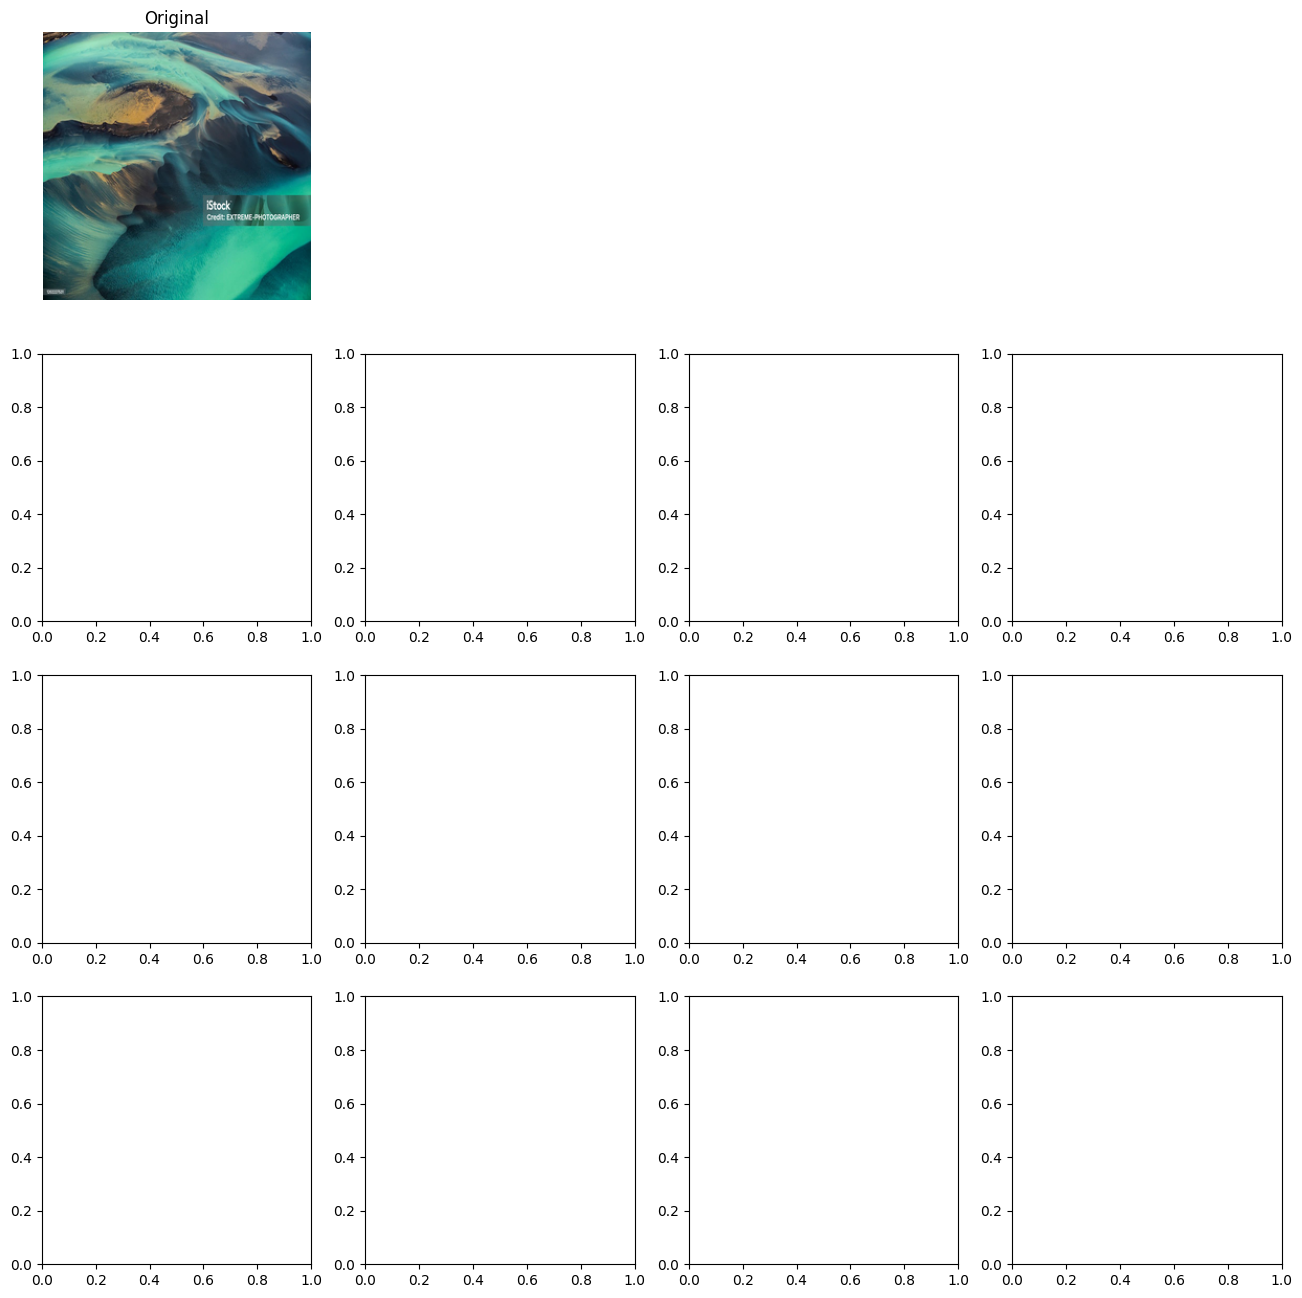

In [7]:
# Test different augmentation strategies
if os.path.exists(train_dir) and len(os.listdir(train_dir)) > 0:
    
    def test_strategy(strategy_name, sample_image_path):
        """Test a specific augmentation strategy."""
        # Temporarily modify config
        original_strategy = aug_config['current_strategy']
        aug_config['current_strategy'] = strategy_name
        
        # Save temporary config
        temp_config_path = "../config/temp_aug_config.yaml"
        with open(temp_config_path, 'w') as f:
            yaml.dump(aug_config, f)
        
        # Create dataset with this strategy
        dataset = AugmentedColorDataset(
            os.path.dirname(sample_image_path),
            temp_config_path,
            is_training=True
        )
        
        # Generate samples
        filename = os.path.basename(sample_image_path)
        try:
            file_idx = dataset.image_files.index(filename)
            samples = []
            
            for _ in range(3):
                L, AB, _ = dataset[file_idx]
                
                # Convert back to RGB
                preprocessor = DataPreprocessor()
                L_denorm = (L + 1.0) / 2.0  # Denormalize
                rgb_images = preprocessor.lab_to_rgb(
                    L_denorm.unsqueeze(0), 
                    AB.unsqueeze(0)
                )
                samples.append(rgb_images[0])
            
            # Clean up
            os.remove(temp_config_path)
            aug_config['current_strategy'] = original_strategy
            
            return samples
            
        except (ValueError, IndexError) as e:
            print(f"Error testing strategy {strategy_name}: {e}")
            # Clean up
            if os.path.exists(temp_config_path):
                os.remove(temp_config_path)
            aug_config['current_strategy'] = original_strategy
            return []
    
    # Test all strategies on the same image
    if sample_files:
        sample_image = os.path.join(train_dir, sample_files[0])
        
        print("Comparing augmentation strategies...")
        
        # Original image
        original_img = Image.open(sample_image)
        original_array = np.array(original_img) / 255.0
        
        fig, axes = plt.subplots(len(strategies) + 1, 4, figsize=(16, 4 * (len(strategies) + 1)))
        
        # Show original
        axes[0, 0].imshow(original_array)
        axes[0, 0].set_title('Original')
        axes[0, 0].axis('off')
        
        # Hide unused original row plots
        for i in range(1, 4):
            axes[0, i].axis('off')
        
        # Test each strategy
        for row, (strategy_name, _) in enumerate(strategies.items(), 1):
            print(f"Testing {strategy_name} strategy...")
            samples = test_strategy(strategy_name, sample_image)
            
            for col, sample in enumerate(samples[:3]):
                axes[row, col].imshow(sample)
                axes[row, col].set_title(f'{strategy_name.title()} #{col+1}')
                axes[row, col].axis('off')
            
            # Hide unused column if less than 3 samples
            for col in range(len(samples), 4):
                axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.savefig('../results/strategy_comparison.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("Strategy comparison saved to ../results/strategy_comparison.png")

else:
    print("No processed data available for strategy testing")

## 5. Analyze Augmentation Effects on Dataset Statistics

In [8]:
# Analyze how augmentation affects dataset statistics
if os.path.exists(train_dir) and len(os.listdir(train_dir)) > 0:
    print("Analyzing augmentation effects on dataset statistics...")
    
    # Create datasets with and without augmentation
    print("Creating datasets for comparison...")
    
    # Dataset without augmentation
    temp_config = aug_config.copy()
    temp_config['augmentation']['enabled'] = False
    
    temp_config_path = "../config/no_aug_config.yaml"
    with open(temp_config_path, 'w') as f:
        yaml.dump(temp_config, f)
    
    dataset_no_aug = AugmentedColorDataset(
        train_dir,
        temp_config_path,
        is_training=False  # No augmentation
    )
    
    # Dataset with augmentation
    dataset_with_aug = AugmentedColorDataset(
        train_dir,
        aug_config_path,
        is_training=True  # With augmentation
    )
    
    # Collect statistics from both datasets
    def collect_stats(dataset, num_samples=50):
        """Collect L and AB channel statistics."""
        L_values = []
        AB_values = []
        
        sample_count = min(num_samples, len(dataset))
        indices = np.random.choice(len(dataset), sample_count, replace=False)
        
        print(f"Collecting statistics from {sample_count} samples...")
        
        for idx in tqdm(indices):
            try:
                L, AB, _ = dataset[idx]
                L_values.append(L.numpy().flatten())
                AB_values.append(AB.numpy().flatten())
            except Exception as e:
                print(f"Error processing sample {idx}: {e}")
        
        if L_values and AB_values:
            L_all = np.concatenate(L_values)
            AB_all = np.concatenate(AB_values)
            
            return {
                'L_mean': np.mean(L_all),
                'L_std': np.std(L_all),
                'L_min': np.min(L_all),
                'L_max': np.max(L_all),
                'AB_mean': np.mean(AB_all),
                'AB_std': np.std(AB_all),
                'AB_min': np.min(AB_all),
                'AB_max': np.max(AB_all),
                'L_values': L_all,
                'AB_values': AB_all
            }
        else:
            return None
    
    # Collect statistics
    print("\nAnalyzing dataset without augmentation...")
    stats_no_aug = collect_stats(dataset_no_aug)
    
    print("\nAnalyzing dataset with augmentation...")
    stats_with_aug = collect_stats(dataset_with_aug)
    
    # Clean up temp config
    os.remove(temp_config_path)
    
    # Compare statistics
    if stats_no_aug and stats_with_aug:
        print("\nStatistical Comparison:")
        print("=" * 50)
        print(f"{'Metric':<15} {'No Aug':<10} {'With Aug':<10} {'Change':<10}")
        print("-" * 50)
        
        metrics = ['L_mean', 'L_std', 'AB_mean', 'AB_std']
        for metric in metrics:
            no_aug_val = stats_no_aug[metric]
            with_aug_val = stats_with_aug[metric]
            change = ((with_aug_val - no_aug_val) / no_aug_val) * 100
            
            print(f"{metric:<15} {no_aug_val:<10.4f} {with_aug_val:<10.4f} {change:<+10.2f}%")
        
        # Plot distributions
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        
        # L channel distribution
        axes[0, 0].hist(stats_no_aug['L_values'][:10000], bins=50, alpha=0.7, 
                       label='No Augmentation', density=True)
        axes[0, 0].hist(stats_with_aug['L_values'][:10000], bins=50, alpha=0.7, 
                       label='With Augmentation', density=True)
        axes[0, 0].set_title('L Channel Distribution')
        axes[0, 0].set_xlabel('L Value')
        axes[0, 0].set_ylabel('Density')
        axes[0, 0].legend()
        
        # AB channel distribution
        axes[0, 1].hist(stats_no_aug['AB_values'][:10000], bins=50, alpha=0.7, 
                       label='No Augmentation', density=True)
        axes[0, 1].hist(stats_with_aug['AB_values'][:10000], bins=50, alpha=0.7, 
                       label='With Augmentation', density=True)
        axes[0, 1].set_title('AB Channels Distribution')
        axes[0, 1].set_xlabel('AB Value')
        axes[0, 1].set_ylabel('Density')
        axes[0, 1].legend()
        
        # Box plots for better comparison
        axes[1, 0].boxplot([stats_no_aug['L_values'][:5000], stats_with_aug['L_values'][:5000]], 
                          labels=['No Aug', 'With Aug'])
        axes[1, 0].set_title('L Channel Box Plot')
        axes[1, 0].set_ylabel('L Value')
        
        axes[1, 1].boxplot([stats_no_aug['AB_values'][:5000], stats_with_aug['AB_values'][:5000]], 
                          labels=['No Aug', 'With Aug'])
        axes[1, 1].set_title('AB Channels Box Plot')
        axes[1, 1].set_ylabel('AB Value')
        
        plt.tight_layout()
        plt.savefig('../results/augmentation_statistics.png', dpi=150, bbox_inches='tight')
        plt.show()
        
        print("\nStatistical analysis saved to ../results/augmentation_statistics.png")
    
    else:
        print("Could not collect statistics for comparison")

else:
    print("No processed data available for statistical analysis")

Analyzing augmentation effects on dataset statistics...
Creating datasets for comparison...


INFO:data_augmentation:Initialized augmented dataset with 9 images
INFO:data_augmentation:Augmentation enabled: False


ValueError: 1 validation error for InitSchema
sigma
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='120 * 0.05', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/float_parsing

## 6. Create Augmented Dataset Samples

In [9]:
# Create a small augmented dataset for experimentation
if os.path.exists(train_dir) and len(os.listdir(train_dir)) > 0:
    print("Creating augmented dataset samples...")
    
    # Create output directory
    aug_sample_dir = "../data/augmented_samples"
    os.makedirs(aug_sample_dir, exist_ok=True)
    
    # Select a few sample images
    sample_files = [f for f in os.listdir(train_dir) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    num_samples = min(5, len(sample_files))
    selected_samples = sample_files[:num_samples]
    
    print(f"Creating augmented versions of {num_samples} images...")
    
    # Create temporary directory with selected samples
    temp_sample_dir = "../data/temp_samples"
    os.makedirs(temp_sample_dir, exist_ok=True)
    
    for filename in selected_samples:
        src = os.path.join(train_dir, filename)
        dst = os.path.join(temp_sample_dir, filename)
        import shutil
        shutil.copy2(src, dst)
    
    # Generate augmented versions
    try:
        create_augmented_dataset(
            temp_sample_dir,
            aug_sample_dir,
            aug_config_path,
            multiplier=3  # Create 3 augmented versions per image
        )
        
        print(f"✓ Augmented samples created in {aug_sample_dir}")
        
        # Count results
        total_images = len([f for f in os.listdir(aug_sample_dir) 
                          if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"Total images in augmented samples: {total_images}")
        print(f"(Original: {num_samples}, Augmented: {total_images - num_samples})")
        
    except Exception as e:
        print(f"Error creating augmented dataset: {e}")
    
    finally:
        # Clean up temporary directory
        if os.path.exists(temp_sample_dir):
            shutil.rmtree(temp_sample_dir)

else:
    print("No processed data available for creating augmented samples")

Creating augmented dataset samples...
Creating augmented versions of 5 images...
Error creating augmented dataset: 1 validation error for InitSchema
sigma
  Input should be a valid number, unable to parse string as a number [type=float_parsing, input_value='120 * 0.05', input_type=str]
    For further information visit https://errors.pydantic.dev/2.11/v/float_parsing


## 7. Recommendation System

In [10]:
# Provide recommendations based on dataset size and analysis
if os.path.exists(train_dir):
    image_count = len([f for f in os.listdir(train_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print("Augmentation Strategy Recommendations:")
    print("=" * 50)
    
    if image_count < 500:
        print("📊 SMALL DATASET DETECTED")
        print(f"You have {image_count} training images")
        print("\n🔧 Recommendations:")
        print("• Use 'heavy' augmentation strategy")
        print("• Enable all geometric augmentations")
        print("• Use high probabilities (0.7-0.9)")
        print("• Consider advanced augmentations")
        print("• Create 5-8x more augmented images")
        
        # Suggest config changes
        print("\n⚙️ Suggested config changes:")
        print("current_strategy: 'heavy'")
        print("augmentation.probability: 0.9")
        
    elif image_count < 2000:
        print("📊 MEDIUM DATASET DETECTED")
        print(f"You have {image_count} training images")
        print("\n🔧 Recommendations:")
        print("• Use 'medium' augmentation strategy")
        print("• Focus on geometric augmentations")
        print("• Use moderate probabilities (0.5-0.7)")
        print("• Create 3-4x more augmented images")
        
        print("\n⚙️ Suggested config changes:")
        print("current_strategy: 'medium'")
        print("augmentation.probability: 0.7")
        
    else:
        print("📊 LARGE DATASET DETECTED")
        print(f"You have {image_count} training images")
        print("\n🔧 Recommendations:")
        print("• Use 'light' augmentation strategy")
        print("• Focus on preserving image quality")
        print("• Use lower probabilities (0.3-0.5)")
        print("• Create 2x more augmented images")
        
        print("\n⚙️ Suggested config changes:")
        print("current_strategy: 'light'")
        print("augmentation.probability: 0.5")
    
    print("\n🎯 General Tips:")
    print("• Start with recommended strategy")
    print("• Monitor training loss for overfitting")
    print("• Reduce augmentation if loss becomes unstable")
    print("• Increase augmentation if model overfits quickly")
    
    print("\n📝 Next Steps:")
    print("1. Modify augmentation_config.yaml with recommendations")
    print("2. Run notebook 04_model_training_baseline.ipynb (no augmentation)")
    print("3. Run notebook 05_model_training_augmented.ipynb (with augmentation)")
    print("4. Compare results in notebook 06_evaluation_comparison.ipynb")

else:
    print("No processed data found for providing recommendations")

Augmentation Strategy Recommendations:
📊 SMALL DATASET DETECTED
You have 9 training images

🔧 Recommendations:
• Use 'heavy' augmentation strategy
• Enable all geometric augmentations
• Use high probabilities (0.7-0.9)
• Consider advanced augmentations
• Create 5-8x more augmented images

⚙️ Suggested config changes:
current_strategy: 'heavy'
augmentation.probability: 0.9

🎯 General Tips:
• Start with recommended strategy
• Monitor training loss for overfitting
• Reduce augmentation if loss becomes unstable
• Increase augmentation if model overfits quickly

📝 Next Steps:
1. Modify augmentation_config.yaml with recommendations
2. Run notebook 04_model_training_baseline.ipynb (no augmentation)
3. Run notebook 05_model_training_augmented.ipynb (with augmentation)
4. Compare results in notebook 06_evaluation_comparison.ipynb


## 8. Save Experiment Results

In [11]:
# Save experiment summary
experiment_summary = {
    'augmentation_experiments_completed': True,
    'strategies_tested': list(strategies.keys()) if 'strategies' in locals() else [],
    'current_strategy': aug_config['current_strategy'],
    'dataset_size': image_count if 'image_count' in locals() else 0,
    'augmentation_enabled': aug_config['augmentation']['enabled'],
    'files_generated': [
        'augmentation_preview.png',
        'strategy_comparison.png',
        'augmentation_statistics.png'
    ]
}

# Save to results directory
results_dir = "../results"
os.makedirs(results_dir, exist_ok=True)

summary_path = os.path.join(results_dir, 'augmentation_experiments.yaml')
with open(summary_path, 'w') as f:
    yaml.dump(experiment_summary, f, default_flow_style=False)

print("Experiment Summary:")
print("=" * 30)
for key, value in experiment_summary.items():
    print(f"{key}: {value}")

print(f"\n✓ Summary saved to: {summary_path}")
print("\n🎉 Augmentation experiments completed!")
print("You're now ready to train models with different augmentation strategies.")

Experiment Summary:
augmentation_experiments_completed: True
strategies_tested: ['light', 'medium', 'heavy']
current_strategy: light
dataset_size: 9
augmentation_enabled: False
files_generated: ['augmentation_preview.png', 'strategy_comparison.png', 'augmentation_statistics.png']

✓ Summary saved to: ../results\augmentation_experiments.yaml

🎉 Augmentation experiments completed!
You're now ready to train models with different augmentation strategies.


## Summary

This notebook helped you:

✅ **Test Augmentation Techniques**: Visualized how different augmentations affect your images

✅ **Compare Strategies**: Tested light, medium, and heavy augmentation approaches  

✅ **Analyze Effects**: Measured how augmentation changes dataset statistics

✅ **Get Recommendations**: Received tailored advice based on your dataset size

### Key Findings:
- **Current Strategy**: {aug_config['current_strategy'] if 'aug_config' in locals() else 'Unknown'}
- **Dataset Size**: {image_count if 'image_count' in locals() else 'Unknown'} images
- **Recommended Approach**: Based on dataset size analysis above

### Next Steps:
1. **Adjust Configuration**: Modify `config/augmentation_config.yaml` based on recommendations
2. **Train Baseline**: Run `04_model_training_baseline.ipynb` without augmentation
3. **Train Augmented**: Run `05_model_training_augmented.ipynb` with augmentation  
4. **Compare Results**: Use `06_evaluation_comparison.ipynb` to see the improvement

The goal is to find the right balance: enough augmentation to improve generalization, but not so much that it hurts image quality! 🎯